# Predictor equipo ganador en Liga MX

Teniendo datos sencillos se intenta obtener algún dato que nos permita determinar que equipo ganará algún encuentro próximo.

El proyecto base fue tomado de éste [video](https://www.youtube.com/watch?v=6tQhoUuQrOw&feature=youtu.be). Se utilizan el código del siguiente [github]().
Los datasets para ésta y otras ligas de futbol pueden ser descargados en el siguiente [enlace](http://football-data.co.uk/data.php).

## Método para solventar el problema

1. Obtener un _dataset_ y preprocesarlo.
2. Entrenar el _dataset_ (12 features & 1 target (winning team (Home/Away/Draw))
3. Verificar distintos clasificadores para encontrar el que mejor se adapte al problema.
    - Logistic Regression.
    - Support Vector Machine.
    - XGBoost.
    - KNN.
4. Utilizar el mejor clasificador para encontrar que equipo ganará.

## Importación de librerías

In [1]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

## Representación del _dataset_

In [2]:
# Read data and drop redundant column.
data = pd.read_csv('./Data/MEX.csv')

# Preview data.
print(display(data.head()))

# Select team to predict
#data = data[data['Home'].str.match('U.N.A.M') | data['Away'].str.match('U.N.A.M')]
#data = data[data['Season'].str.match('2018/2019') | data['Season'].str.match('2019/2020')]
data = data[data['Home'].str.match('U.N.A.M')]

data = data.dropna()
#last_twenty = data.tail(20)
last_four = data.tail(4)

print(display(data.head()))

# Delete country, league, season, date, home team name, away team name
data.drop(['Country', 'League', 'Season', 'Date', 'Time', 'Home', 'Away'], axis=1, inplace=True)
print(display(data.head()))

#Res (H=Home Win, D=Draw, A=Away Win)
#HG - Home goals
#AG - away goals

#Input - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
#Output - Full Time Result (H=Home Win, D=Draw, A=Away Win) 

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Mexico,Liga MX,2012/2013,21/07/2012,01:30,Chiapas,U.A.N.L.- Tigres,0,4,A,2.93,3.34,2.60,2.95,3.50,2.64,2.74,3.10,2.51
1,Mexico,Liga MX,2012/2013,21/07/2012,03:30,Club Tijuana,Puebla,2,0,H,1.91,3.58,4.49,2.24,3.58,4.49,1.93,3.26,3.83
2,Mexico,Liga MX,2012/2013,21/07/2012,23:00,Cruz Azul,Monarcas,0,0,D,2.02,3.53,4.13,2.10,3.70,4.13,2.00,3.26,3.56
3,Mexico,Liga MX,2012/2013,21/07/2012,23:00,Queretaro,Club Leon,0,2,A,3.82,3.25,2.22,3.82,3.35,2.29,3.26,3.18,2.16
4,Mexico,Liga MX,2012/2013,22/07/2012,01:00,Monterrey,Club America,0,0,D,1.85,3.87,4.50,2.10,3.87,4.50,1.92,3.37,3.79


None


,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
16,Mexico,Liga MX,2012/2013,29/07/2012,18:00,U.N.A.M.- Pumas,Queretaro,3,0,H,1.61,3.97,6.77,1.66,3.97,6.77,1.57,3.69,5.60
34,Mexico,Liga MX,2012/2013,12/08/2012,18:00,U.N.A.M.- Pumas,Toluca,1,2,A,2.06,3.48,3.96,2.10,3.50,3.96,2.02,3.23,3.52
51,Mexico,Liga MX,2012/2013,26/08/2012,18:00,U.N.A.M.- Pumas,Cruz Azul,0,1,A,2.79,3.26,2.76,2.80,3.30,3.25,2.50,3.10,2.76
70,Mexico,Liga MX,2012/2013,16/09/2012,18:00,U.N.A.M.- Pumas,Atl. San Luis,0,1,A,1.82,3.74,4.82,1.83,3.74,5.50,1.74,3.46,4.55
88,Mexico,Liga MX,2012/2013,30/09/2012,18:00,U.N.A.M.- Pumas,Puebla,2,1,H,1.85,3.68,4.62,1.91,3.68,4.65,1.83,3.35,4.21


None


,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
16,3,0,H,1.61,3.97,6.77,1.66,3.97,6.77,1.57,3.69,5.60
34,1,2,A,2.06,3.48,3.96,2.10,3.50,3.96,2.02,3.23,3.52
51,0,1,A,2.79,3.26,2.76,2.80,3.30,3.25,2.50,3.10,2.76
70,0,1,A,1.82,3.74,4.82,1.83,3.74,5.50,1.74,3.46,4.55
88,2,1,H,1.85,3.68,4.62,1.91,3.68,4.65,1.83,3.35,4.21


None


## Exploración de los datos

In [3]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.Res == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 142
Number of features: 11
Number of matches won by home team: 59
Win rate of home team: 41.55%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3000712210>,
      dtype=object)

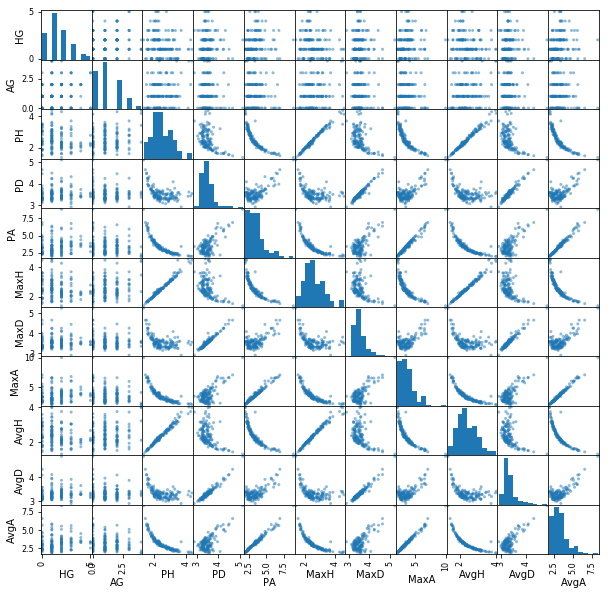

In [4]:
# Visualising distribution of data
from pandas.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

scatter_matrix(data[['HG', 'AG', 'Res', 'PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']], figsize=(10,10))

## Preparando los datos para el entrenamiento

In [5]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['Res'], 1)
y_all = data['Res']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HG', 'AG', 'PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']]
for col in cols:
    X_all[col] = scale(X_all[col])
    

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':


In [6]:
#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (11 total features):
['HG', 'AG', 'PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']


In [7]:
# Show the feature information by printing the first five rows
print("\nFeature values:")
print(display(X_all.head()))


Feature values:


,HG,AG,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
16,1.22331,-1.138885,-1.452983,1.425179,2.840468,-1.412642,1.269722,2.513094,-1.485866,1.378423,2.294089
34,-0.40777,0.786373,-0.719431,-0.134493,0.432864,-0.733757,-0.195376,0.271756,-0.664385,-0.374665,0.257167
51,-1.22331,-0.176256,0.470552,-0.834754,-0.595294,0.346288,-0.818822,-0.294561,0.211863,-0.870103,-0.487093
70,-1.22331,-0.176256,-1.110659,0.693088,1.169711,-1.150345,0.552759,1.500105,-1.175529,0.501879,1.265835
88,0.40777,-0.176256,-1.061755,0.502108,0.998351,-1.026912,0.365726,0.822120,-1.011232,0.082662,0.932877


None


In [8]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.4,
                                                    random_state = 2,
                                                    stratify = y_all)


## Training and Evaluating Models

In [9]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, labels='H', average='micro'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

Logistic Regression

![alt text](https://image.slidesharecdn.com/logisticregression-predictingthechancesofcoronaryheartdisease-091203130638-phpapp01/95/logistic-regression-predicting-the-chances-of-coronary-heart-disease-2-728.jpg?cb=1259845609"Logo Title Text 1")

![alt text](https://i.ytimg.com/vi/HdB-z0TJRK4/maxresdefault.jpg "Logo Title Text 1")

Support Vector Machine

![alt text](https://image.slidesharecdn.com/supportvectormachine-121112135318-phpapp01/95/support-vector-machine-3-638.jpg?cb=1352729591 "Logo Title Text 1")
![alt text](http://docs.opencv.org/2.4/_images/optimal-hyperplane.png "Logo Title Text 1")

XGBoost

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png "Logo Title Text 1")

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-17-638.jpg?cb=1450092771 "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-18-638.jpg?cb=1450092771 "Logo Title Text 1")

In [10]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42, solver='newton-cg', multi_class='auto')
clf_B = SVC(random_state = 912, kernel='rbf', gamma='scale')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

from sklearn.neighbors import KNeighborsClassifier
clf_D = KNeighborsClassifier(n_neighbors = 5)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print('')

Training a LogisticRegression using a training set size of 85. . .
Trained model in 0.0293 seconds
Made predictions in 0.0026 seconds.
(1.0, 1.0)
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0024 seconds.
F1 score and accuracy score for test set: 1.0000 , 1.0000.

Training a SVC using a training set size of 85. . .
Trained model in 0.0043 seconds
Made predictions in 0.0026 seconds.
(0.8985507246376812, 0.8470588235294118)
F1 score and accuracy score for training set: 0.8986 , 0.8471.
Made predictions in 0.0022 seconds.
F1 score and accuracy score for test set: 0.8636 , 0.6842.

Training a XGBClassifier using a training set size of 85. . .
Trained model in 0.0737 seconds
Made predictions in 0.0026 seconds.
(1.0, 1.0)
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0021 seconds.
F1 score and accuracy score for test set: 0.9362 , 0.9474.

Training a KNeighborsClassifier using a training set size of 85. . .
Traine

**Clearly XGBoost seems like the best model as it has the highest F1 score and accuracy score on the test set.**

# Tuning the parameters of XGBoost.

![alt text](https://i.stack.imgur.com/9GgQK.jpg "Logo Title Text 1")

In [11]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.01],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=None,
                        param_grid=parameters,
                        cv=5,
                        iid=False
                       )

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=2, silent=True, subsample=0.8)
Made predictions in 0.0020 seconds.
F1 score and accuracy score for training set: 0.9211 , 0.9176.
Made predictions in 0.0015 seconds.
F1 score and accuracy score for test set: 0.8846 , 0.8070.


In [12]:
#prediction
print('Valores del dataset:\t\t{}\n'.format(list(last_four['Res'])))
print('Clasificador 1 (regresión):\t{}\n'.format(list(clf_A.predict(X_test))[-4:]))
print('Clasificador 2 (vector):\t{}\n'.format(list(clf_B.predict(X_test))[-4:]))
print('Clasificador 3 (árboles):\t{}\n'.format(list(clf_C.predict(X_test))[-4:]))
print('Clasificador 3 (optimizado):\t{}\n'.format(list(clf.predict(X_test))[-4:]))
print('Clasificador 4 (KNN):\t\t{}\n'.format(list(clf_D.predict(X_test))[-4:]))

Valores del dataset:		['H', 'H', 'A', 'D']

Clasificador 1 (regresión):	['A', 'D', 'D', 'D']

Clasificador 2 (vector):	['D', 'A', 'D', 'D']

Clasificador 3 (árboles):	['A', 'D', 'H', 'D']

Clasificador 3 (optimizado):	['A', 'A', 'H', 'H']

Clasificador 4 (KNN):		['A', 'A', 'D', 'D']

